## Code for retrieving ERA5 Data

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import earthkit.data

### I only used one square from ERA5 - is this okay practice?

In [2]:
## updated for HEF
lat = 46.79
lng = 10.74

variable = "total_precipitation"

"Snowfall", 2m temperature
date_range = ["1940-01-01", "2100-12-31"]

In [4]:
def retrieve_data(variable, date_range, lat, lng):
    # Define the dataset and request parameters
    dataset = "reanalysis-era5-single-levels-timeseries"
    request = {
        "variable": [
        variable,  # Variable to retrieve
        ],
        "date": date_range,  # Date range for the data
        "location": {"longitude": lng, "latitude": lat},  # Location coordinates
        "data_format": "netcdf"  # Format of the retrieved data
    }

    # Use "earthkit" to retrieve the data
    ekds = earthkit.data.from_source(
        "cds", dataset, request
    ).to_xarray()

    return ekds

In [5]:
data = retrieve_data(variable, date_range, lat, lng)

2025-04-28 14:33:46,202 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-28 14:33:46,203 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-28 14:33:46,340 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-28 14:33:46,341 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-28 14:33:46,573 WARNING [2025-03-17T00:00:00] Please be aware that the generation of this dataset 

1a51f72e087fe59aefbdcfc1d89169e1.zip:   0%|          | 0.00/8.57M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

#### This saves the ERA5 data locally

In [6]:
import xarray as xr


# Join the dates into a string, separated by 'to' (e.g., '1940-01-01_to_2100-12-31')
date_range_str = f"{date_range[0]}_to_{date_range[1]}"

# Create the filename
file_name = f"era5_data/era5_{variable}_{date_range_str}_lat_{lat}_lng_{lng}.nc"

# Save xarray Dataset to a NetCDF file
data.to_netcdf(file_name)

# Load the dataset back from the NetCDF file
dataset_from_netcdf = xr.open_dataset(file_name)


#### Load ERA5 data locally

In [6]:
import xarray as xr

date_range_str = f"{date_range[0]}_to_{date_range[1]}"
file_name = f"era5_data/era5_{variable}_{date_range_str}_lat_{lat}_lng_{lng}.nc"

# Load the dataset back from the NetCDF file
data = xr.open_dataset(file_name)

In [19]:
print(data.head())

<xarray.Dataset> Size: 76B
Dimensions:     (valid_time: 5)
Coordinates:
    latitude    float64 8B 46.75
    longitude   float64 8B 10.75
  * valid_time  (valid_time) datetime64[ns] 40B 1940-01-01 ... 1940-01-01T04:...
Data variables:
    tp          (valid_time) float32 20B ...
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2024-09-02T04:48 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts


#### A series of functions, which find annual precip accum, hydro-year precip accum and monthly accum, resamples from the hourly ERA5 data

In [62]:
def truncate_data(var):
    """
    Truncate the input dataset to include only complete years where the final hour
    of December 31st is present in the dataset.

    Args:
        var (xarray.Dataset or xarray.DataArray): Input dataset containing a 'valid_time'
                                                  coordinate with datetime information.

    Returns:
        xarray.Dataset or xarray.DataArray: The truncated dataset containing data
                                            only for complete years.
    """
    # Create a range of the final hours of each year in the dataset
    start_year = var.valid_time.dt.year.min().item()
    end_year = var.valid_time.dt.year.max().item()

    final_hours = pd.date_range(
        f"{start_year}-12-31T23:00:00", 
        f"{end_year}-12-31T23:00:00", 
        freq="YE"
    )

    # Filter only the years where the final hour is in the dataset
    valid_years = [
        dt.year for dt in final_hours if dt in var.valid_time
    ]

    # Select data for those years
    var_truncated = var.sel(
        valid_time=var.valid_time.dt.year.isin(valid_years)
    )

    return var_truncated


# Function to compute the annual mean precipitation time series
def precipAnnualTimeseries():
    """
    Processes the annual timeseries of precipitation data.

    This function reads precipitation data from a NetCDF file, removes data
    for the incomplete current year, resamples the data to annual sums, and
    converts the values to millimeters.

    Returns:
        tuple: A tuple containing two elements:
            - years (numpy.ndarray): Years corresponding to the annual precip sums.
            - values (numpy.ndarray): Annual precipitation sums in millimeters.
    """
    data_tp_pt = data.tp

    # Remove incomplete years
    data_tp_pt_trun = truncate_data(data_tp_pt)

    # Resample the data to annual sums and convert to mm
    data_tp_pt_agg = data_tp_pt_trun.resample(
        valid_time="YE"
    ).sum() * 1000

    years = data_tp_pt_agg.valid_time.to_index().year
    values = data_tp_pt_agg.values.flatten()

    # Get the actual lat/lon used
    nearest_lat = data_tp_pt.latitude.values
    nearest_lng = data_tp_pt.longitude.values

    return years, values, nearest_lat, nearest_lng

def precipHydroyearTimeseries():
    """
    Processes the annual timeseries of precipitation data.

    This function reads precipitation data from a NetCDF file, removes data
    for the incomplete current year, resamples the data to annual sums, and
    converts the values to millimeters.

    Returns:
        tuple: A tuple containing two elements:
            - years (numpy.ndarray): Years corresponding to the annual precip sums.
            - values (numpy.ndarray): Annual precipitation sums in millimeters.
    """
    data_tp_pt = data.tp

    # Remove incomplete years
    data_tp_pt_trun = truncate_data(data_tp_pt)

    # Resample the data to annual sums and convert to mm
    data_tp_pt_agg = data_tp_pt_trun.resample(
        valid_time="YE-SEP"  ## Check this is right.
    ).sum() * 1000

    years = data_tp_pt_agg.valid_time.to_index().year # 2023/2024 year is 2024 hydro year.
    values = data_tp_pt_agg.values.flatten()

    # Get the actual lat/lon used
    nearest_lat = data_tp_pt.latitude.values
    nearest_lng = data_tp_pt.longitude.values

    return years, values, nearest_lat, nearest_lng


def precipMonthlyTimeseries():
    """
    Processes the monthly timeseries of precipitation data.

    This function reads precipitation data from a NetCDF file, removes data
    for the incomplete current year, resamples the data to monthly sums, and
    converts the values to millimeters.

    Returns:
        pandas.DataFrame: A DataFrame containing columns for year, month,
                          hydrological year, and the monthly
                          precipitation values.
    """
    data_tp_pt = data.tp

    # Remove incomplete years
    data_tp_pt_trun = truncate_data(data_tp_pt)

    # Resample the data to monthly sums and convert to mm
    data_tp_pt_agg = data_tp_pt_trun.resample(
        valid_time="MS"  # Resample by calendar month start
    ).sum() * 1000

    # Extract months, years, and values
    months = data_tp_pt_agg.valid_time.to_index().month
    years = data_tp_pt_agg.valid_time.to_index().year
    values = data_tp_pt_agg.values.flatten()

    # Create the DataFrame
    df = pd.DataFrame({
        'year': years,
        'month': months,
        'precipitation_mm': values,
    })

    # Add hydrological-style year (starts in Oct)
    df['hydrological_year'] = df.apply(
        lambda row: row['year'] + 1 if row['month'] >= 10 else row['year'],
        axis=1
    )

    # Get the actual lat/lon used
    nearest_lat = data_tp_pt.latitude.values
    nearest_lng = data_tp_pt.longitude.values

    # Add lat/lon to the DataFrame
    df['latitude'] = nearest_lat
    df['longitude'] = nearest_lng

    return df



# Example of how to call the function and inspect the result
df_monthly = precipMonthlyTimeseries()
df_monthly['Date'] = pd.to_datetime(df_monthly[['year', 'month']].assign(day=1))


# Save to a data frame
file_name_monthly_df = f"era5_data/era5_monthly{variable}_{date_range_str}_lat_{lat}_lng_{lng}.pkl"
df_monthly.to_pickle(file_name_monthly_df)

print(df_monthly)

# Pivot to get monthly precip as columns (1–12)

# df_pivot = df_precip.pivot(index='calendar_year', columns='month', values='precipitation_mm')

# # Rename columns to month names for clarity
# df_pivot.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
#                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# print(df_pivot)




      year  month  precipitation_mm  hydrological_year  latitude  longitude  \
0     1940      1         20.965576             1940.0     46.75      10.75   
1     1940      2         43.271782             1940.0     46.75      10.75   
2     1940      3         41.060448             1940.0     46.75      10.75   
3     1940      4         70.344208             1940.0     46.75      10.75   
4     1940      5        111.400368             1940.0     46.75      10.75   
...    ...    ...               ...                ...       ...        ...   
1015  2024      8         46.393394             2024.0     46.75      10.75   
1016  2024      9        130.291931             2024.0     46.75      10.75   
1017  2024     10        121.397018             2025.0     46.75      10.75   
1018  2024     11         31.334400             2025.0     46.75      10.75   
1019  2024     12         60.023308             2025.0     46.75      10.75   

           Date  
0    1940-01-01  
1    1940-02-01

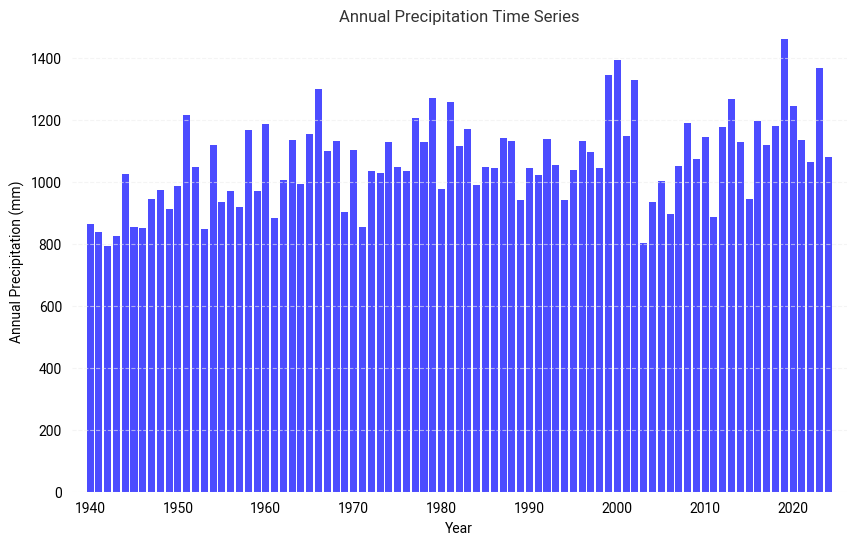

10.75
46.75


In [8]:
##Sanity check to make sure I am plotting the right ERA5 data


import matplotlib.pyplot as plt

# Call the function to get the data
years, values, nearest_lat, nearest_lng = precipAnnualTimeseries()

# Plot the data as a bar graph
plt.figure(figsize=(10, 6))
plt.bar(years, values, color='b', alpha=0.7)  # Bar plot with blue color and transparency
plt.xlabel("Year")
plt.ylabel("Annual Precipitation (mm)")
plt.title("Annual Precipitation Time Series")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

print(nearest_lng)
print(nearest_lat)




In [78]:
def precipSeasonTimeseries(df_monthly):
    """
    Given a monthly precipitation DataFrame with columns 'year', 'month', 'precipitation_mm', and 'hydrological_year',
    assign seasons and seasonal hydrological years, then aggregate seasonal precipitation sums.

    Args:
        df_monthly (pd.DataFrame): Output of precipMonthlyTimeseries(), must contain 'year', 'month',
                                  'precipitation_mm', and 'hydrological_year' columns.

    Returns:
        pd.DataFrame: Seasonal precipitation sums with columns ['seasonal_hydro_year', 'season', 'precipitation_mm'].
    """
    # Define season assignment function
    def month_to_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Autumn'

    # Assign seasons
    df_monthly['season'] = df_monthly['month'].apply(month_to_season)

    # Assign seasonal hydrological year, with September shifting to next hydrological year
    df_monthly['seasonal_hydro_year'] = df_monthly.apply(
        lambda row: row['hydrological_year'] + 1 if row['month'] == 9 else row['hydrological_year'],
        axis=1
    )

    # Aggregate seasonal precipitation sums
    seasonal_precip = (
        df_monthly.groupby(['seasonal_hydro_year', 'season'])['precipitation_mm']
        .sum()
        .reset_index()
        .sort_values(['seasonal_hydro_year', 'season'])
    )

    return seasonal_precip


df_monthly = precipMonthlyTimeseries()
df_seasonal = precipSeasonTimeseries(df_monthly)
print(df_seasonal)



     seasonal_hydro_year  season  precipitation_mm
0                 1940.0  Spring        222.805023
1                 1940.0  Summer        332.479492
2                 1940.0  Winter         64.237358
3                 1941.0  Autumn        197.779175
4                 1941.0  Spring        244.159698
..                   ...     ...               ...
336               2024.0  Spring        382.678497
337               2024.0  Summer        219.994080
338               2024.0  Winter        289.501648
339               2025.0  Autumn        283.023346
340               2025.0  Winter         60.023308

[341 rows x 3 columns]


## Load in HEF MB data

In [72]:
df_hef_MB = pd.read_pickle("hef_MB_combined.pkl")

import calendar

# After pivoting and resetting index:
df_pivoted = df_monthly.pivot_table(
    index='hydrological_year',
    columns='month',
    values='precipitation_mm',
    aggfunc='sum'
).reset_index()

# Create list of month abbreviations with '_precip_total' suffix
month_names = [f"{calendar.month_abbr[m]}_precip_total" for m in range(1, 13)]

# Rename columns accordingly
df_pivoted.columns = ['hydrological_year'] + month_names

# Merge with your mass balance data as before
df_merged = pd.merge(df_pivoted, df_hef_MB, on='hydrological_year', how='inner')

# Calculate annual precip and merge
annual_precip = df_monthly.groupby('hydrological_year')['precipitation_mm'].sum().reset_index()
annual_precip.rename(columns={'precipitation_mm': 'annual_precip'}, inplace=True)
df_combined = df_merged.merge(annual_precip, on='hydrological_year', how='left')

print(df_combined.head())



   hydrological_year  Jan_precip_total  Feb_precip_total  Mar_precip_total  \
0             1954.0         94.801903         25.869370         51.248787   
1             1955.0         54.097893        102.002625         51.678658   
2             1956.0         67.228554         19.608498         80.867531   
3             1957.0         44.280769         95.008377         36.222694   
4             1958.0         77.376846        105.499504         54.314377   

   Apr_precip_total  May_precip_total  Jun_precip_total  Jul_precip_total  \
0         93.107460        145.035980        118.181702        118.990898   
1         46.059845        101.775650         73.597908        169.332504   
2        103.196144         80.521584        139.960526        119.459869   
3         57.351349         98.239182        111.915588        153.239960   
4        112.402916         58.983803        144.169098        140.103333   

   Aug_precip_total  Sep_precip_total  ...  calendar_year  \
0      

## 15052025 I want to make a correlation table using combined winter and summer MB



In [69]:
from scipy.stats import t
from tabulate import tabulate

# Assuming the DataFrame is already loaded as df

# Allow the user to specify columns for correlation calculation
columns_to_compare = ["climatic mass balance", "annual_precip",  "combined winter balance", "summer balance"]

# Filter the DataFrame to include only the specified columns
numeric_df = df_combined[columns_to_compare].select_dtypes(include=[np.number])


# Calculate the correlation matrix
corr_matrix = numeric_df.corr()
n = len(numeric_df)

# Function to calculate the critical t-value for a given correlation and sample size
def is_significant(r, n, alpha=0.05):
    if np.isnan(r):
        return False
    t_value = r * np.sqrt((n - 2) / (1 - r**2))
    critical_value = t.ppf(1 - alpha / 2, n - 2)
    return abs(t_value) > critical_value

# Create a new DataFrame to store the formatted correlations
formatted_corr = corr_matrix.copy()

# Apply bold formatting for significant correlations
for row in formatted_corr.index:
    for col in formatted_corr.columns:
        r = corr_matrix.loc[row, col]
        if is_significant(r, n):
            formatted_corr.loc[row, col] = f'**{r:.2f}**'  # Bold format
        else:
            formatted_corr.loc[row, col] = f'{r:.2f}'

# Display the formatted correlation table as a pretty table
print("\nCorrelation Matrix with Significant Values (Bold):")
print(tabulate(formatted_corr, headers="keys", tablefmt="pretty", showindex=True))



Correlation Matrix with Significant Values (Bold):
+-------------------------+-----------------------+---------------+-------------------------+----------------+
|                         | climatic mass balance | annual_precip | combined winter balance | summer balance |
+-------------------------+-----------------------+---------------+-------------------------+----------------+
|  climatic mass balance  |       **1.00**        |   **0.29**    |        **-0.28**        |    **0.95**    |
|      annual_precip      |       **0.29**        |   **1.00**    |        **0.54**         |      0.08      |
| combined winter balance |       **-0.28**       |   **0.54**    |        **1.00**         |   **-0.56**    |
|     summer balance      |       **0.95**        |     0.08      |        **-0.56**        |    **1.00**    |
+-------------------------+-----------------------+---------------+-------------------------+----------------+


/tmp/ipykernel_781/3508136232.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  t_value = r * np.sqrt((n - 2) / (1 - r**2))
/tmp/ipykernel_781/3508136232.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '**1.00**' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  formatted_corr.loc[row, col] = f'**{r:.2f}**'  # Bold format
/tmp/ipykernel_781/3508136232.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '**0.29**' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  formatted_corr.loc[row, col] = f'**{r:.2f}**'  # Bold format
/tmp/ipykernel_781/3508136232.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '**-0.28**' has dtype incompatible w

In [57]:
# Step 1: Define functions to assign seasons and seasonal hydrological years
def assign_season(row):
    month = row['month']
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'autumn'

def assign_seasonal_hydro_year(row):
    if row['month'] == 9:  # September is part of the next hydro year
        return row['hydrological_year'] + 1
    else:
        return row['hydrological_year']

# Step 2: Create new columns in the original DataFrame
df_merged['season'] = df_merged.apply(assign_season, axis=1)
df_merged['seasonal_hydro_year'] = df_merged.apply(assign_seasonal_hydro_year, axis=1)

# Step 3: Calculate seasonal precipitation totals
seasonal_precip = (
    df_merged.groupby(['seasonal_hydro_year', 'season'])['precipitation_mm']
    .sum()
    .unstack(fill_value=0)
    .reset_index()
)

# Step 4: Rename columns for clarity
seasonal_precip.columns = ['seasonal_hydro_year', 'autumn_precip', 'spring_precip', 'summer_precip', 'winter_precip']

# Step 5: Merge the seasonal precipitation totals back into the original DataFrame
df_merged = pd.merge(df_merged, seasonal_precip, on='seasonal_hydro_year', how='left')

# Check the result
print(df_merged.head())


In [58]:

# Step 3: Calculate seasonal precipitation totals
seasonal_precip = (
    df_merged.groupby(['seasonal_hydro_year', 'season'])['precipitation_mm']
    .sum()
    .unstack(fill_value=0)
    .reset_index()
)

# Step 4: Rename columns for clarity
seasonal_precip.columns = ['seasonal_hydro_year', 'autumn_precip', 'spring_precip', 'summer_precip', 'winter_precip']

# Step 5: Merge the seasonal precipitation totals back into the original DataFrame
df_merged = pd.merge(df_merged, seasonal_precip, on='seasonal_hydro_year', how='left')

# Check the result
print(df_merged[0:13])

    year  month  precipitation_mm  hydrological_year  latitude  longitude  \
0   1953     10        112.755058             1954.0     46.75      10.75   
1   1953     11          6.618500             1954.0     46.75      10.75   
2   1953     12         22.446394             1954.0     46.75      10.75   
3   1954      1         94.801903             1954.0     46.75      10.75   
4   1954      2         25.869370             1954.0     46.75      10.75   
5   1954      3         51.248787             1954.0     46.75      10.75   
6   1954      4         93.107460             1954.0     46.75      10.75   
7   1954      5        145.035980             1954.0     46.75      10.75   
8   1954      6        118.181702             1954.0     46.75      10.75   
9   1954      7        118.990898             1954.0     46.75      10.75   
10  1954      8        154.703384             1954.0     46.75      10.75   
11  1954      9         77.400925             1954.0     46.75      10.75   

In [59]:
# Step 1: Aggregate data by hydrological year and season
seasonal_agg = df_merged.groupby(['seasonal_hydro_year', 'season']).agg({
    'precipitation_mm': 'sum',
    'climatic mass balance': 'mean',
    'combined winter balance': 'mean',
    'summer balance': 'mean'
}).reset_index()

# Step 2: Pivot to get one row per year
seasonal_wide = seasonal_agg.pivot(index='seasonal_hydro_year', columns='season', values='precipitation_mm').reset_index()

# Step 3: Merge mass balance data back into the seasonal DataFrame
seasonal_wide = pd.merge(seasonal_wide, 
                         df_merged[['hydrological_year', 'climatic mass balance', 'combined winter balance', 'summer balance']].drop_duplicates(),
                         left_on='seasonal_hydro_year', right_on='hydrological_year', how='left')

# Step 4: Drop redundant columns and calculate correlations
seasonal_wide = seasonal_wide.drop(columns=['hydrological_year'])
corr_matrix = seasonal_wide.corr()

# Step 5: Display the correlation matrix
print("\nCorrelation Matrix (Aggregated by Season/Year):")
print(tabulate(corr_matrix, headers="keys", tablefmt="pretty", showindex=True))



Correlation Matrix (Aggregated by Season/Year):
+-------------------------+---------------------+----------------------+----------------------+----------------------+---------------------+-----------------------+-------------------------+----------------------+
|                         | seasonal_hydro_year |        autumn        |        spring        |        summer        |       winter        | climatic mass balance | combined winter balance |    summer balance    |
+-------------------------+---------------------+----------------------+----------------------+----------------------+---------------------+-----------------------+-------------------------+----------------------+
|   seasonal_hydro_year   |         1.0         |  0.2498104040448747  | 0.01460961873885895  | 0.17951541230995277  | 0.03926865257919635 |  -0.6656171619903478  |   0.7394013686206693    | -0.8108581120294327  |
|         autumn          | 0.2498104040448747  |         1.0          | -0.08837182592280579 |

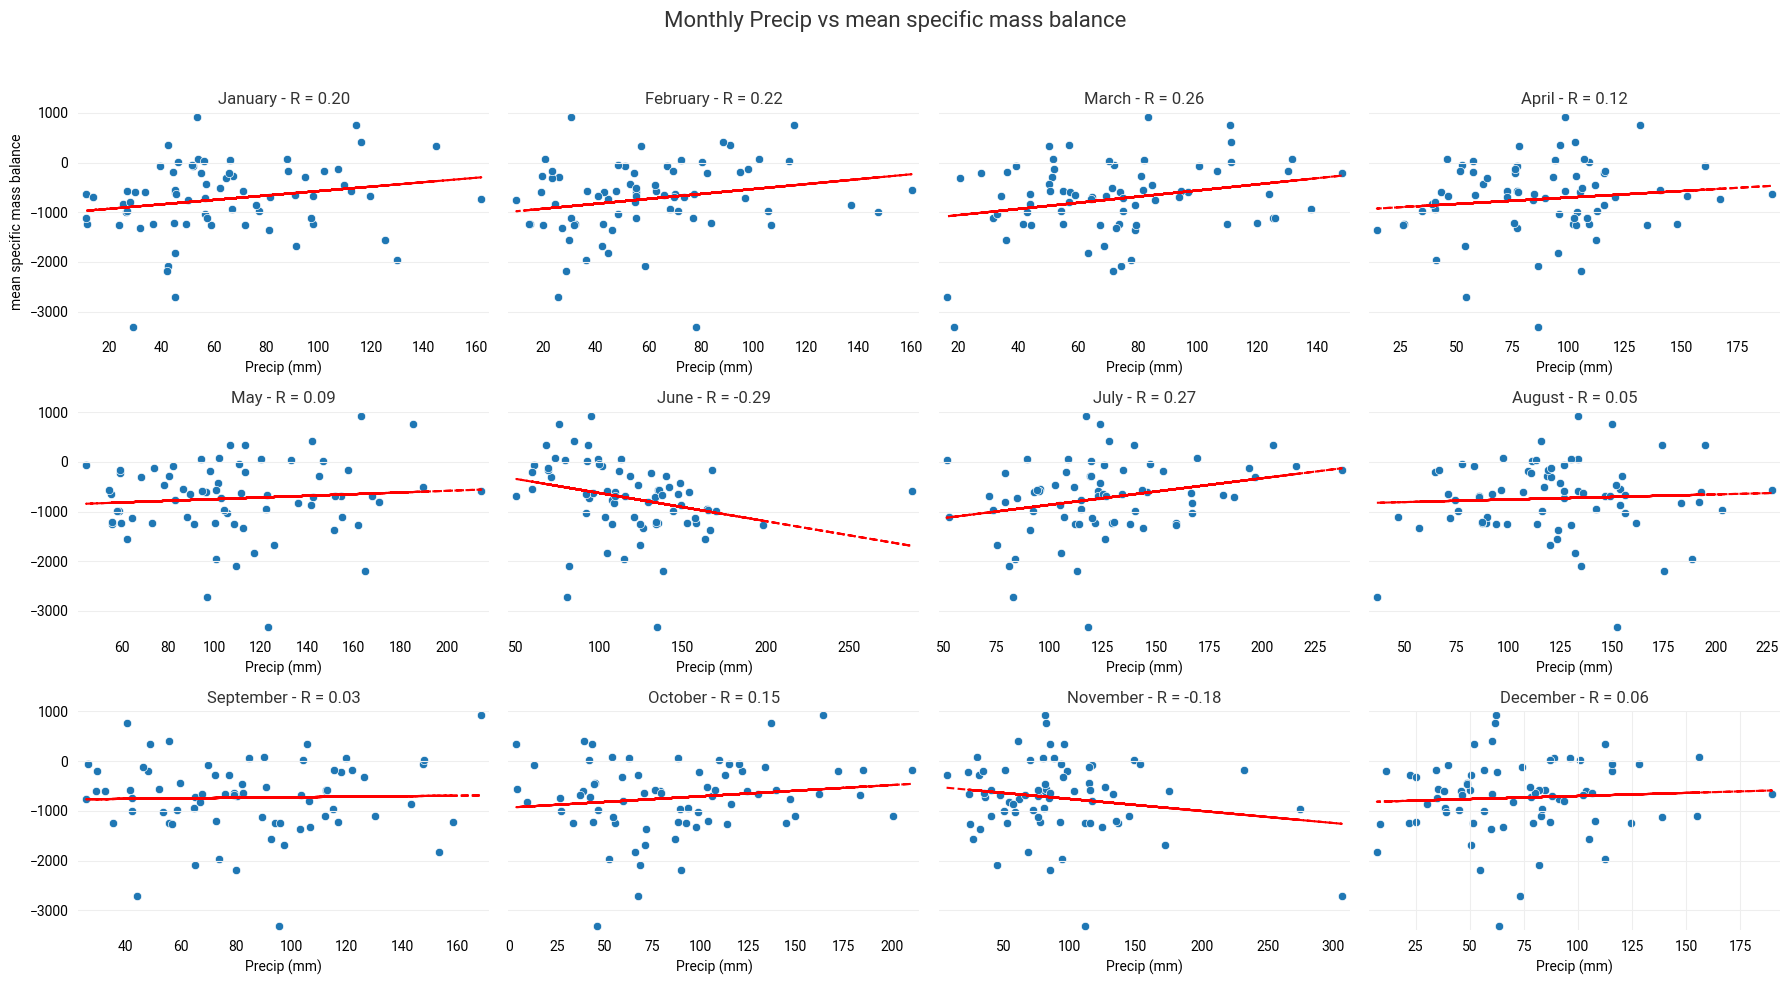

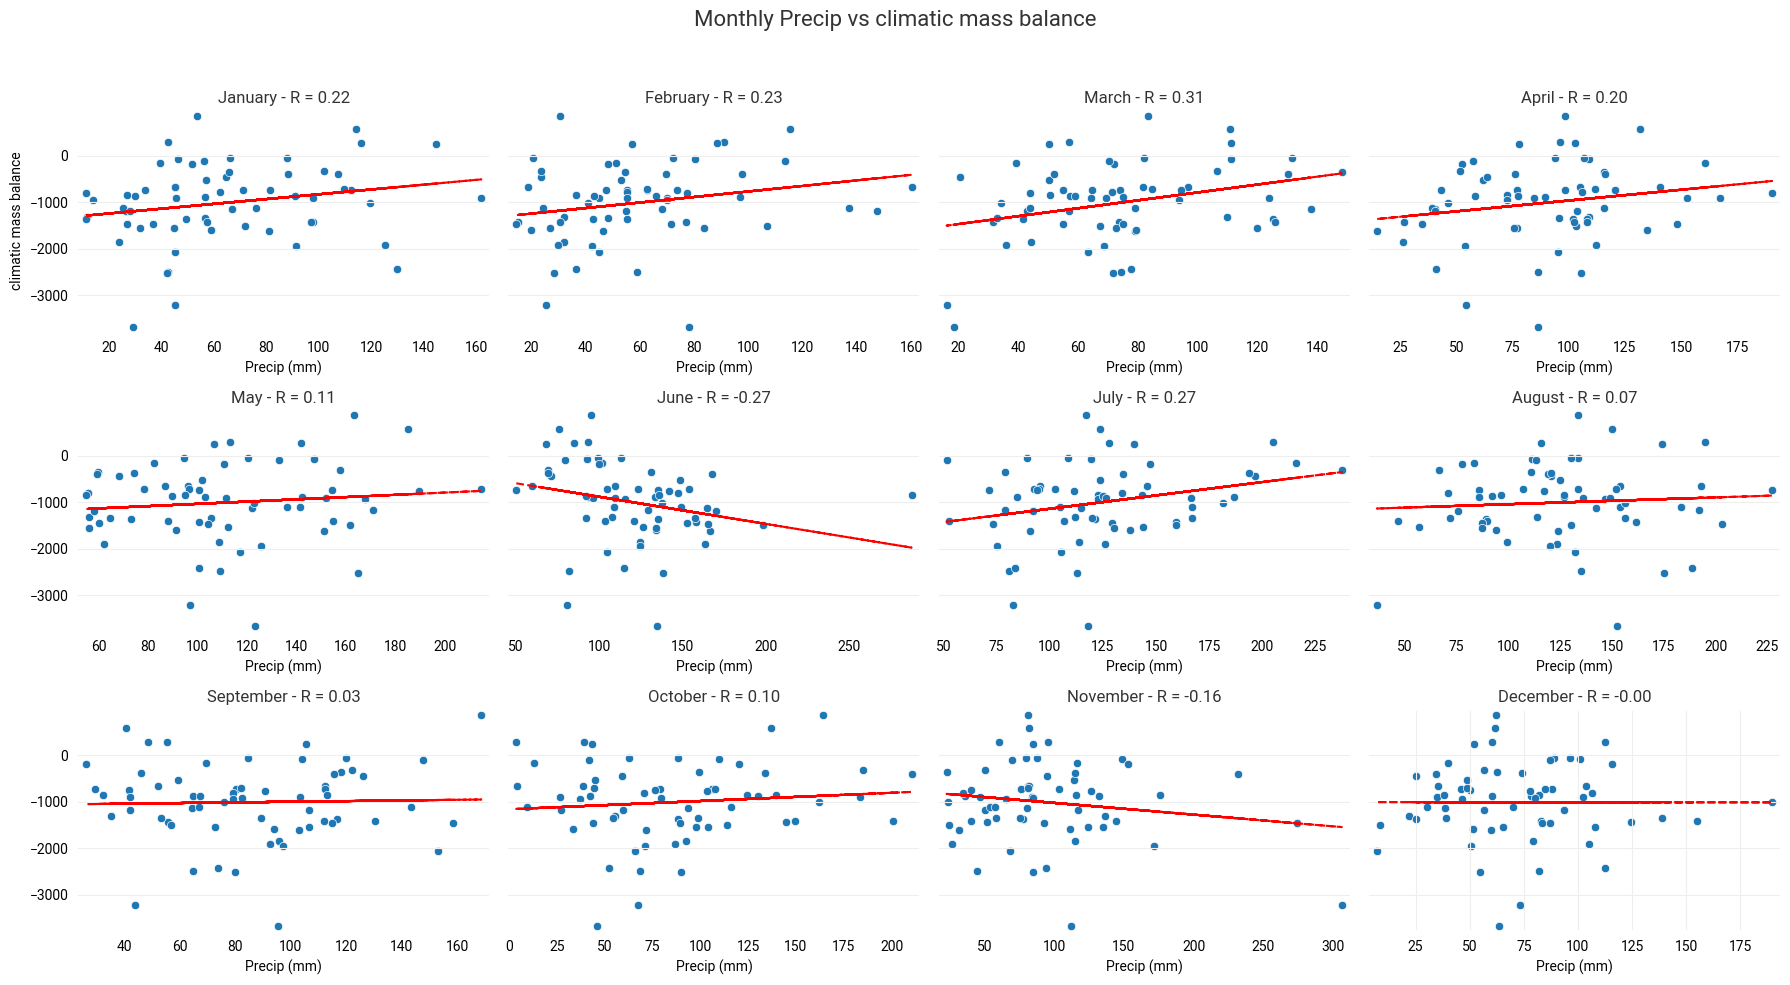

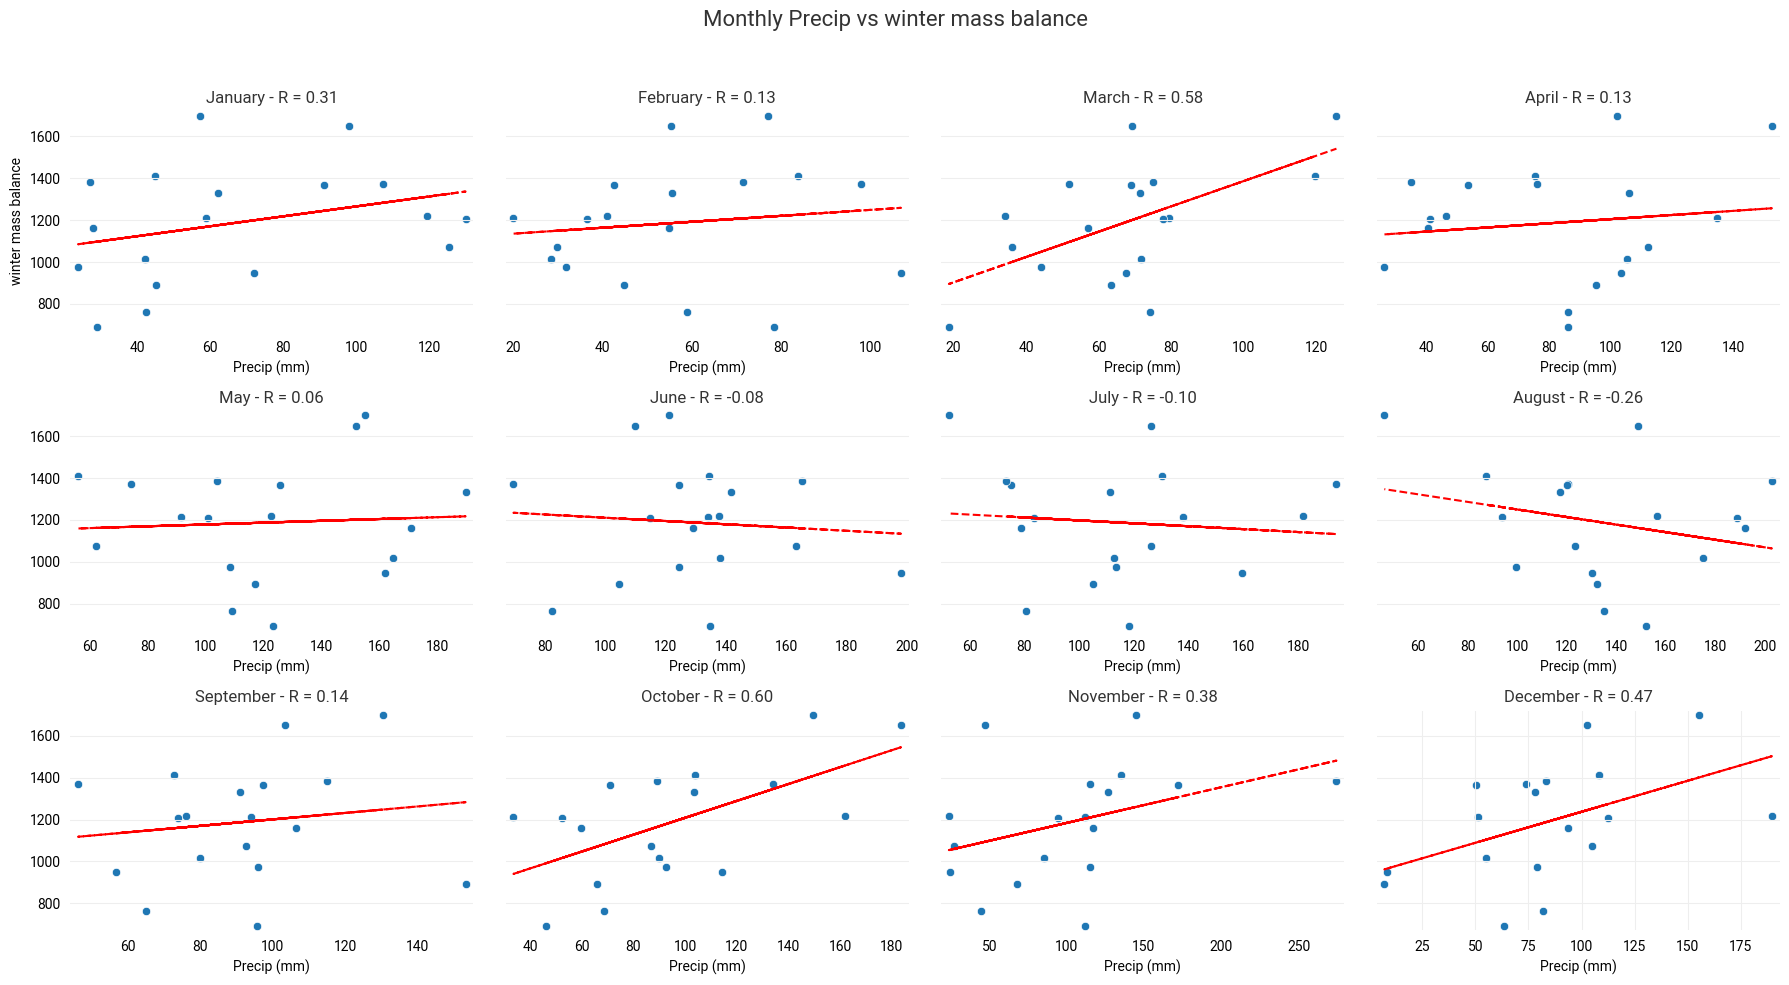

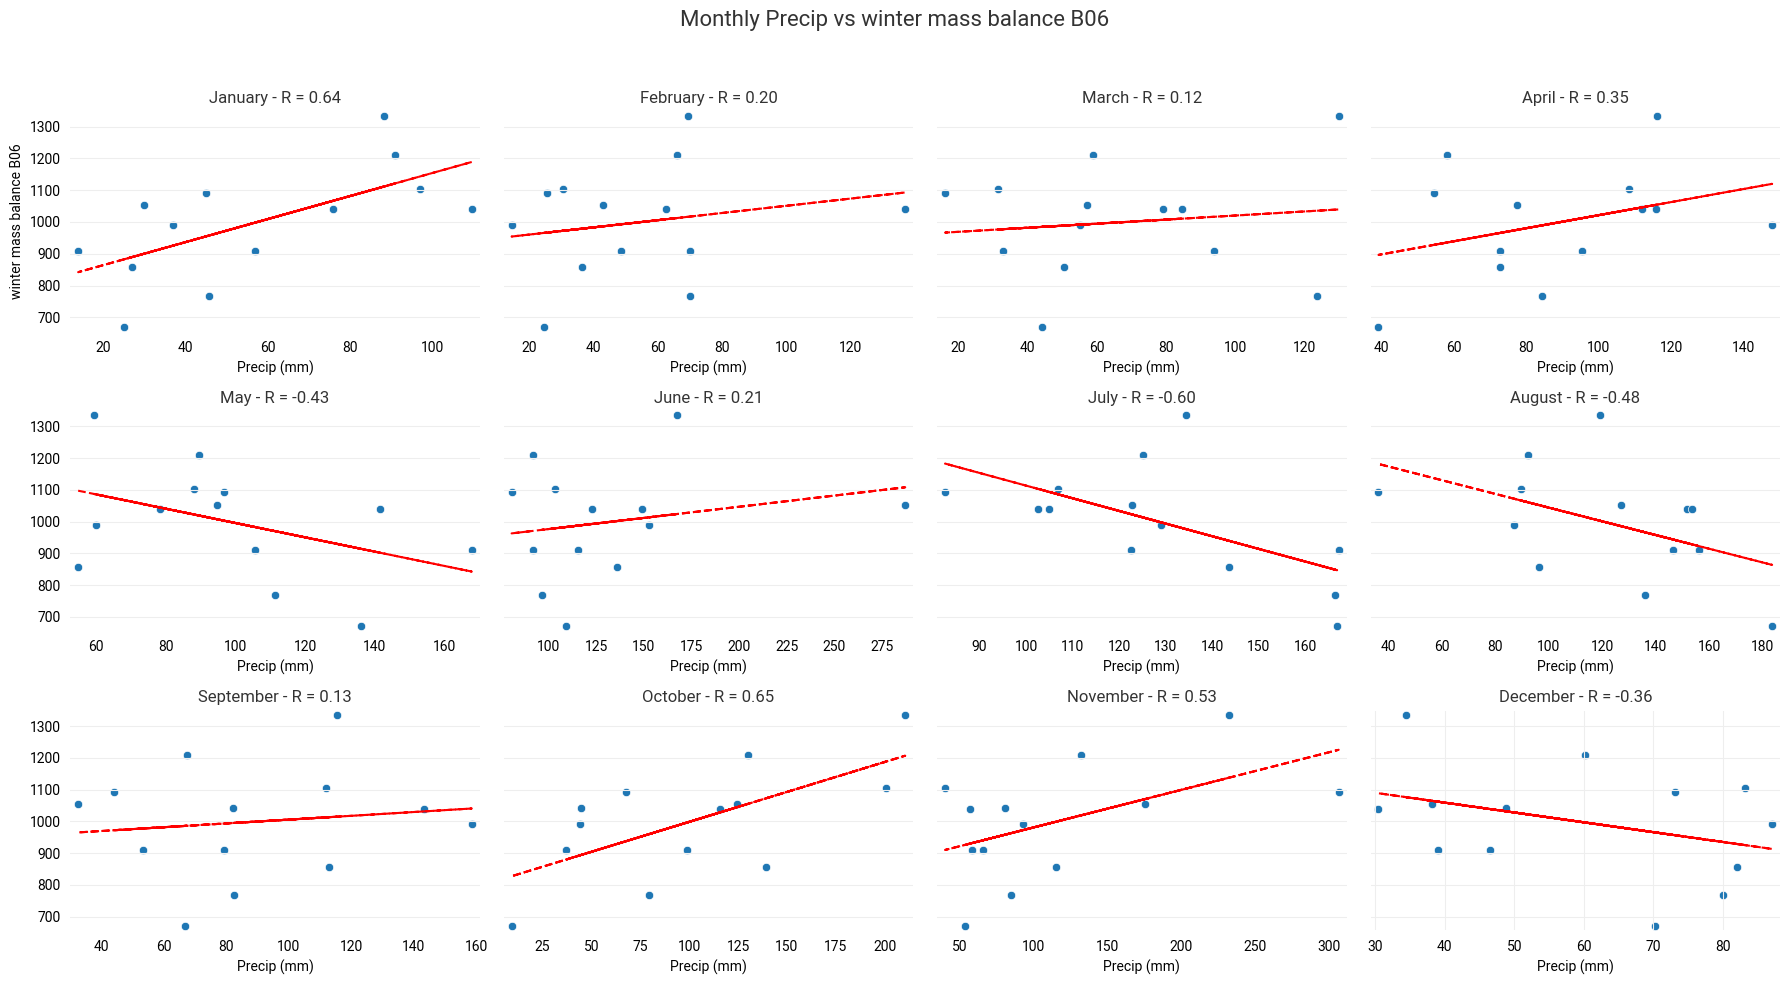

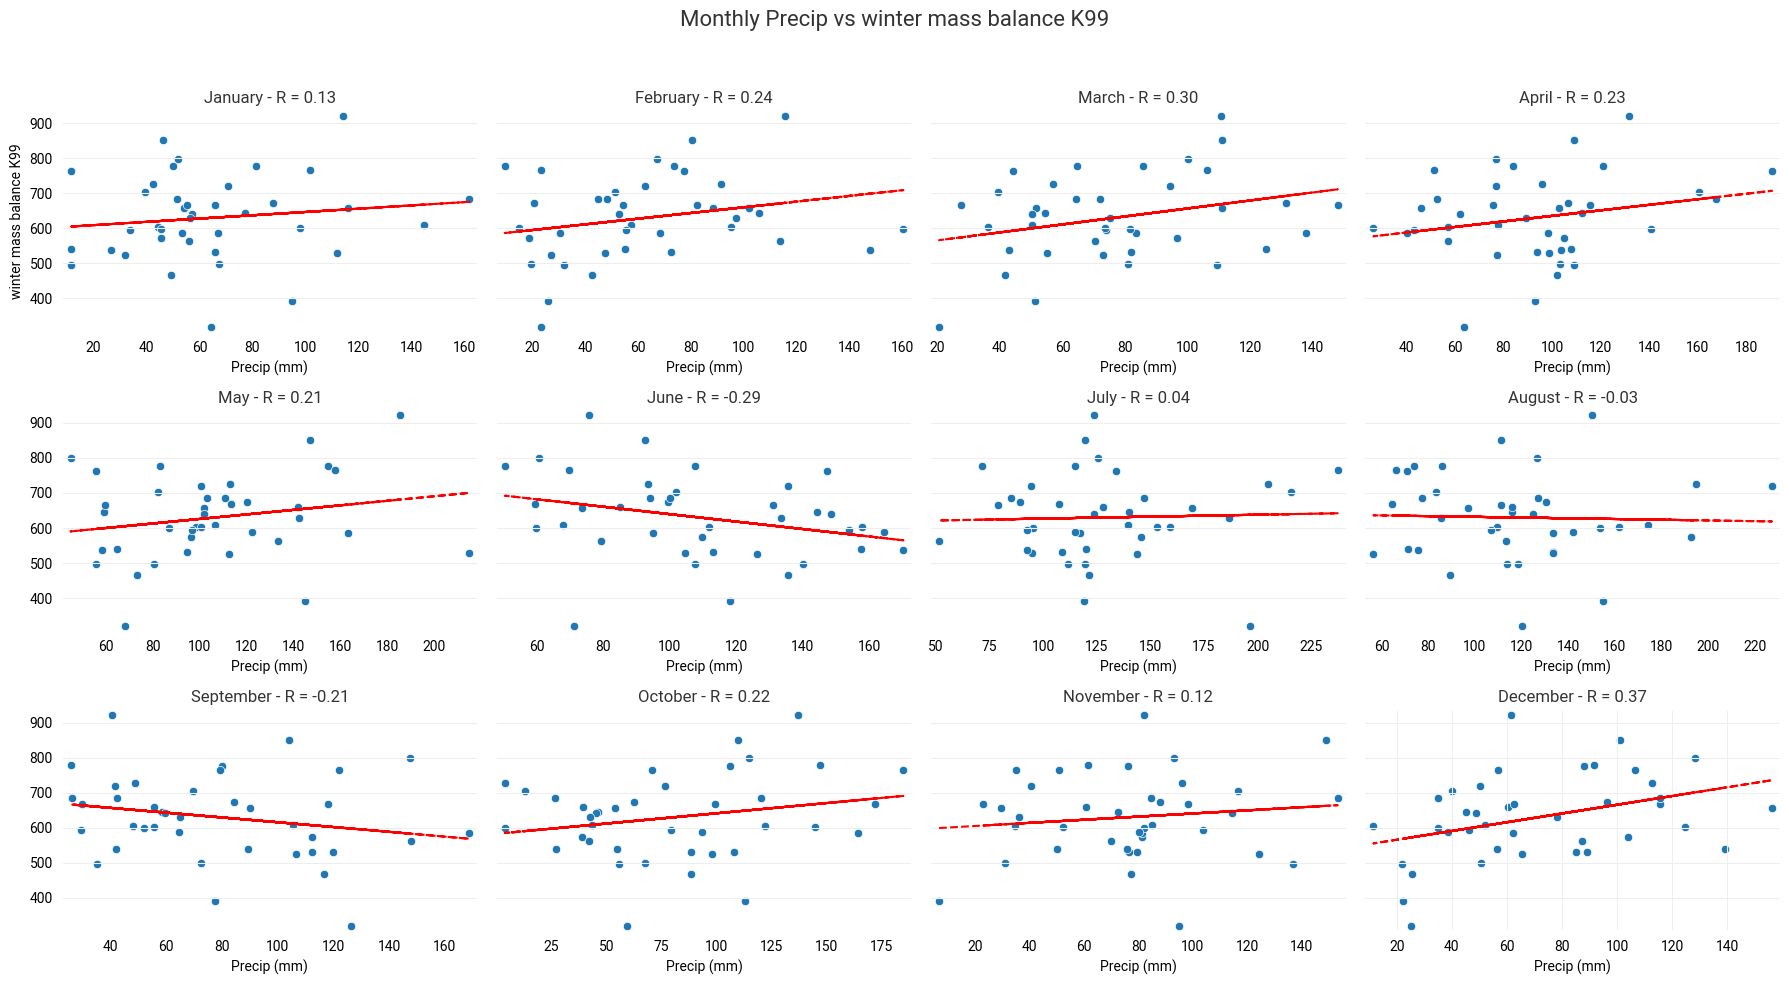

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import pandas as pd

# List of month names
month_names = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

mb_cols = [
    'mean specific mass balance',
    'climatic mass balance',
    'winter mass balance',
    'winter mass balance B06',
    'winter mass balance K99'
]

for mb_col in mb_cols:
    fig, axs = plt.subplots(3, 4, figsize=(18, 10), sharey=True)
    axs = axs.flatten()

    for month in range(1, 13):
        ax = axs[month - 1]
        df_temp = df_merged[df_merged["month"] == month]
        df_temp = df_temp.dropna(subset=["precipitation_mm", mb_col])  # Drop NaNs from this subset

        # Check if there is any valid data for plotting
        if df_temp.empty or df_temp[mb_col].isna().all():
            ax.set_title(f"{month_names[month-1]}\n(no data)")
            continue

        # Get precipitation and mass balance
        x = df_temp["precipitation_mm"]
        y = df_temp[mb_col]

        # Convert y to numeric, forcing errors to NaN
        y = pd.to_numeric(df_temp[mb_col], errors='coerce')

        # Drop NaNs and filter valid data
        valid = (~x.isna()) & (~y.isna())
        x_valid = x[valid]
        y_valid = y[valid]

        # Ensure there are at least two valid data points
        if len(x_valid) < 2:
            ax.set_title(f"{month_names[month-1]}\n(<2 pts)")
            continue

        # Scatter plot
        sns.scatterplot(x=x_valid, y=y_valid, ax=ax, color="tab:blue", label=None)

        # Perform linear regression and plot line of best fit
        try:
            slope, intercept, r_value, _, _ = linregress(x_valid, y_valid)
            ax.plot(x_valid, slope * x_valid + intercept, color="red", linestyle="--")
            ax.set_title(f"{month_names[month-1]} - R = {r_value:.2f}")
        except Exception as e:
            ax.set_title(f"{month_names[month-1]}\n(Error: {str(e)})")

        # Set labels only for the first month
        ax.set_xlabel("Precip (mm)")
        ax.set_ylabel(mb_col if month == 1 else "")  # Label only for the first month

    # Set a title for the entire figure
    plt.suptitle(f"Monthly Precip vs {mb_col}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.grid(True)
    plt.show()



## I should do this for March/April, not May/June. Looking at the graphs it looks like March precip has the biggest impact


/tmp/ipykernel_482/2000094074.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_may_june['combined_precipitation_mm'] = df_may_june.groupby('year')['precipitation_mm'].transform('sum')


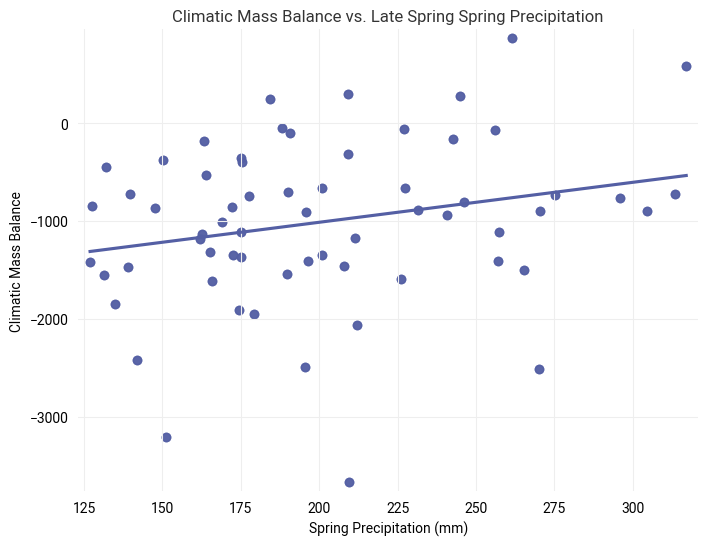

Correlation coefficient: 0.238


In [17]:

# Filter data for May and June
df_may_june = df_merged[df_merged["month"].isin([4, 5])]

# Combine precipitation for May and June by summing the values
df_may_june['combined_precipitation_mm'] = df_may_june.groupby('year')['precipitation_mm'].transform('sum')

# Drop NaN values for plotting only
df_plot = df_may_june.dropna(subset=["combined_precipitation_mm", "climatic mass balance"])

# Now plot using the cleaned data
plt.figure(figsize=(8, 6))
sns.regplot(x=df_plot["combined_precipitation_mm"], y=df_plot["climatic mass balance"], ci=None)  # ci=None removes confidence interval
plt.xlabel("Spring Precipitation (mm)")  # Label for combined precipitation
plt.ylabel("Climatic Mass Balance")
plt.title("Climatic Mass Balance vs. Late Spring Spring Precipitation")
plt.grid(True)
plt.show()

# Calculate correlation
correlation = df_plot["combined_precipitation_mm"].corr(df_plot["climatic mass balance"])
print(f"Correlation coefficient: {correlation:.3f}")
